In [1]:
import pickle
import numpy as np
import pandas as pd
import os
from MINE.gtm import GTM
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 20, 15
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

SMALL_SIZE = 10
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
def mergeSort(arr,left,right):
    mid = 0
    inv_count = 0
    if(left < right):
        mid = (left + right ) // 2

        #recursively seeing the inversion pairs on left child
        inv_count += mergeSort(arr,left,mid)
        
        #recursively seeing the inversion pairs on right child
        inv_count += mergeSort(arr,mid+1,right)

        #Finding the inversion pairs in merge operation
        inv_count += merge(arr,left,mid,right)

    return inv_count
    
def merge(arr,left,mid,right):
    temp_arr = []
    i = left
    j = mid+1
    inv_count = 0

    while(i<=mid and j<=right):
        if(arr[i] <= arr[j]):
            #if arr[i]<=arr[j] then its not an inversion pair
            temp_arr.append(arr[i])
            i+=1
        else:
            #if arr[i]>arr[j] then its an inversion pair and arr[j] is an inversion
            #pair with all the elements from i to end of first subarray(i.e mid)
            temp_arr.append(arr[j])
            inv_count += mid - i + 1
            j+=1

    #completeing the array if some elements are left out
    while(i<=mid):
        temp_arr.append(arr[i])
        i+=1

    while(j<=right):
        temp_arr.append(arr[j])
        j+=1

    #transfering this back to the original array
    for i in range(left,right+1):
        arr[i] = temp_arr[i-left]

    return inv_count

In [3]:
def flatten_dict(d):
    if not isinstance(d, dict):
#         if isinstance(d, np.ndarray):
#             return [list(d)]
        return [[d]]
    result = []
    for k, v in d.items():
        flattened = flatten_dict(v)
        for f in flattened:
            result.append([k] + f)
    return result

In [4]:
def load_results(path):
    columns = ['gamma', 'n', 'method', 'seed', 'selection']
    with open(path, 'rb') as fd:
        results = pickle.load(fd)
    results = pd.DataFrame(flatten_dict(results), columns=columns)
    results.method = results.method.map(
    {'classif': 'classif', 
     'opt': 'opt',
    'classif_b': 'classif_aug',
    'opt_b': 'opt_aug',
    'classif_b_avg': 'classif_aug_avg',
    'opt_b_avg': 'opt_aug_avg',
    'diff_classif': 'diff_classif',
    'diff_opt': 'diff_opt'})
    m = {'opt': 'original', 'classif': 'original', 'opt_aug': 'augmentation', 'classif_aug': 'augmentation', 'opt_aug_avg': 'avg augmentation',
    'classif_aug_avg': 'avg augmentation', 'diff_opt': 'diff', 'diff_classif': 'diff', 'ksg': 'ksg'}
    results['group'] = results.method.map(m)
    return results

def load_ksg(path):
    from ast import literal_eval
    results = pd.read_csv(path, index_col=0)
    results['method'] = 'ksg'
    results.selection = results.selection.apply(literal_eval)
    results['group'] = 'ksg'
    return results

def add_metrics(results):
    results['mae'] = results.selection.apply(lambda x: np.abs(x - np.arange(11)).mean())
    results['inversions'] = results.selection.apply(lambda x: mergeSort(x.copy(),0,len(x)-1))
    results['correct'] = results.inversions == 0
    results['redundant_correct'] = results.selection.apply(lambda x: x[-1] == 10)
#     results['progressive'] = results.selection.apply(lambda x: [mergeSort(x[:i].copy(),0,i-1) for i in range(1, 12)])
    results['progressive'] = results.selection.apply(lambda x: np.array([(x[:i] == np.arange(i)).mean() for i in range(1, 12)]).astype(int))
    
    return results

In [5]:
def aggregate_results(r):
    columns = ['gamma', 'n', 'method', 'group']
    agg = r.groupby(columns).agg({
    'mae': [lambda x: x.mean(), lambda x: np.std(x) / np.sqrt(len(x))],
    'inversions': [lambda x: x.mean(), lambda x: np.std(x) / np.sqrt(len(x))],
        'correct': [lambda x: x.mean(), lambda x: np.std(x) / np.sqrt(len(x))],
    'redundant_correct': [lambda x: x.mean(), lambda x: np.std(x) / np.sqrt(len(x))]
})
    agg.columns = ['mae', 'mae_std', 'inversions', 'inversions_std', 'correct', 'correct_std', 'redundant_correct', 'redundant_correct_std']
    
    return agg

In [6]:
results = load_results('clean_results/results_sel.pkl')
results2 = load_ksg('clean_results/ksg_selection.csv')
results = pd.concat((results, results2))

In [7]:
results = add_metrics(results)
agg = aggregate_results(results)

In [8]:
results.loc[results.method != 'ksg'].groupby(['gamma', 'n', 'method']).size()

gamma  n      method         
0.6    1000   classif            100
              classif_aug        100
              classif_aug_avg    100
              diff_classif       100
              diff_opt           100
                                ... 
0.9    10000  diff_classif       100
              diff_opt           100
              opt                100
              opt_aug            100
              opt_aug_avg        100
Length: 72, dtype: int64

# Eksperymenty

Przeprowadziłem następujące eksperymenty. Mamy ponownie 3 gammy: 0.6, 0.75 oraz 0.9 i 3 liczności 1000, 5000 oraz 10000. Łącznie 9 typów zbiorów danych. Każdy ze zbiorów został wygenerowany niezależnie 50 razy. Na każdym zbiorze wraz z każdą jego instancją została dokonana selekcja zmiennych prz użyciu następujących metod CMINE:

* opt z dwoma sąsiadami
* opt_b z dwoma sąsiadami
* opt_b_avg z dwoma sąsiadami
* diff_opt
* classif z trzema sąsiadami

Pierwsza zmienna została zawsze znaleziona metodą MINE 'opt'. Każda kolejna zmienna została znaleziona przez znalezienie zmiennej, która maksymalizuje CMI poza zmienną targetową oraz zmienną-kandydatem, gdzie w warunku są wszystkie dotychczas wybrane zmienne.

Wyniki są rozpatrywane ze względu na dwie miary: MAE oraz inwersje. MAE jest średnią odległością zmiennej od jej miejsca docelowego. Inwersje to liczba niespójnych par zmiennych (par, gdzie zmienna mniej ważna została wybrana wcześniej). Inwersje są bardziej czułą miarą, ponieważ badają relacje pomiędzy wszystkimi zmiennymi, a nie same położenia. Przykład, który to obrazuje:

* [1, 5, 3, 4, 2]
    * MAE: 1.2
    * inwersje: 5

* [1, 3, 5, 4, 2]
    * MAE: 1.2
    * inwersje 4
    
Zwiększyło nam się "uporządkowanie" (zmienne są lepiej rozstawione), ale tylko inwersje to odzwierciedlają.

### Inwersje

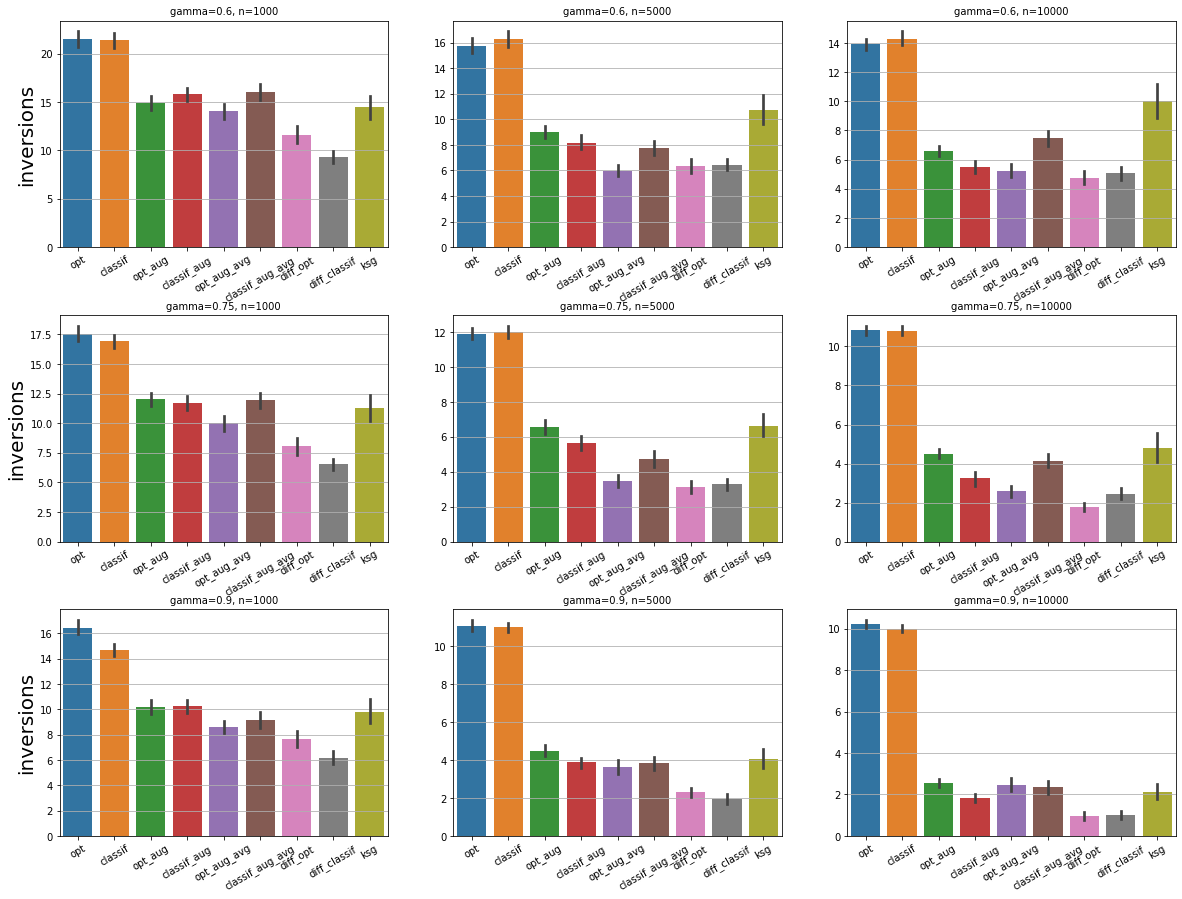

In [9]:
fig, ax = plt.subplots(3, 3)
for i, gamma in enumerate([0.6, 0.75, 0.9]):
    for j, n in enumerate([1000, 5000, 10000]):
        sns.barplot(x='method', y='inversions', data=results.set_index(['gamma', 'n']).loc[gamma, n].reset_index(), ax=ax[i][j],
                   order=['opt', 'classif', 'opt_aug', 'classif_aug', 'opt_aug_avg', 'classif_aug_avg', 'diff_opt', 'diff_classif', 'ksg'])
        ax[i][j].set_title(f'gamma={gamma}, n={n}')
        ax[i][j].set_xlabel(None)
        ax[i][j].grid(axis='y')
        ax[i][j].set_xticklabels(['opt', 'classif', 'opt_aug', 'classif_aug', 'opt_aug_avg', 'classif_aug_avg', 'diff_opt', 'diff_classif', 'ksg'], rotation=30)
        if j != 0:
            ax[i][j].set_ylabel(None)
plt.subplots_adjust(hspace=0.3)
plt.savefig(f'plots/selection/selection_inversions.png', bbox_inches='tight')

### MAE

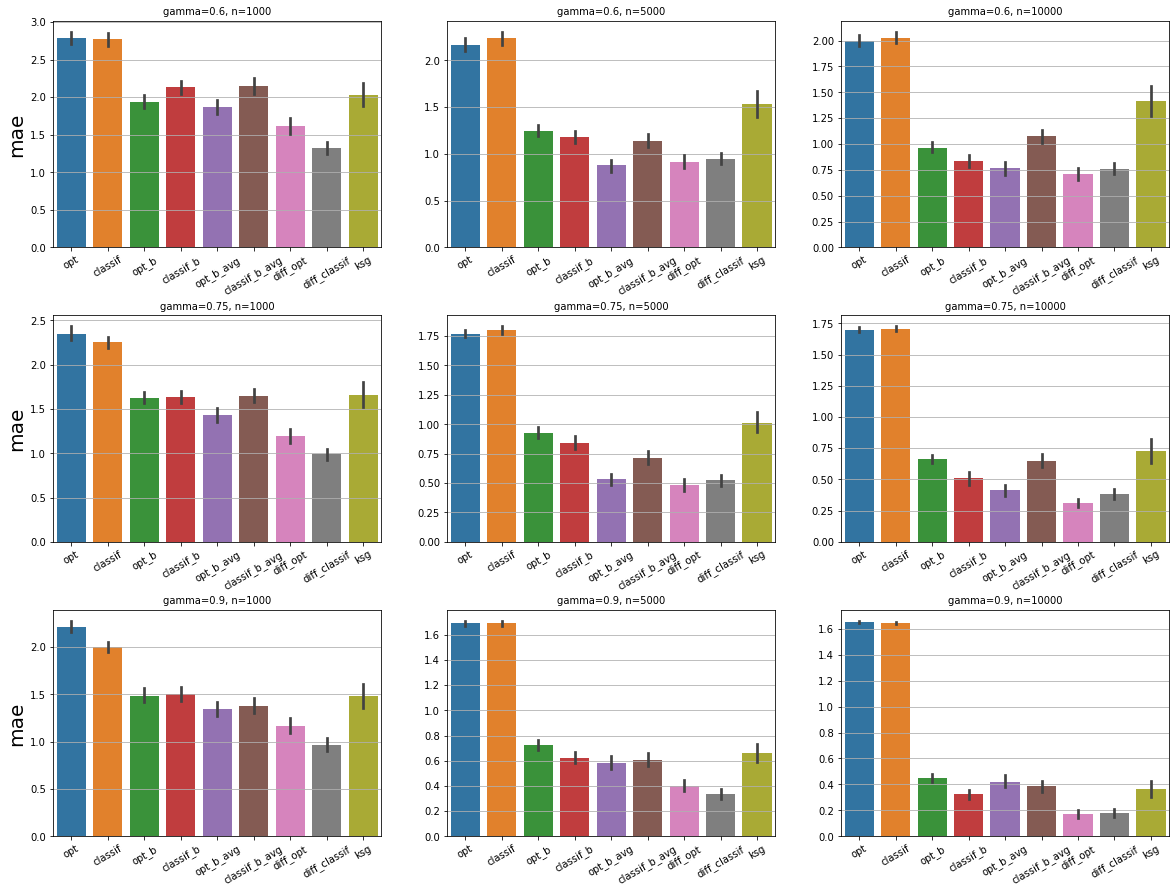

In [10]:
fig, ax = plt.subplots(3, 3)
for i, gamma in enumerate([0.6, 0.75, 0.9]):
    for j, n in enumerate([1000, 5000, 10000]):
        sns.barplot(x='method', y='mae', data=results.set_index(['gamma', 'n']).loc[gamma, n].reset_index(), ax=ax[i][j],
                                      order=['opt', 'classif', 'opt_b', 'classif_b', 'opt_b_avg', 'classif_b_avg', 'diff_opt', 'diff_classif', 'ksg'])
        ax[i][j].set_title(f'gamma={gamma}, n={n}')
        ax[i][j].set_xlabel(None)
        ax[i][j].grid(axis='y')
        ax[i][j].set_xticklabels(['opt', 'classif', 'opt_b', 'classif_b', 'opt_b_avg', 'classif_b_avg', 'diff_opt', 'diff_classif', 'ksg'], rotation=30)
        if j != 0:
            ax[i][j].set_ylabel(None)
plt.subplots_adjust(hspace=0.3)
plt.savefig(f'plots/selection/selection_mae.png', bbox_inches='tight')

### Progresja

In [15]:
def plot_progression(methods='all'):
    tmp = results.copy()
    if methods != 'all':
        tmp = tmp.loc[tmp.method.isin(methods)]
    else:
        methods = ['opt_aug', 'classif_aug', 'opt_aug_avg', 'classif_aug_avg', 'diff_opt', 'diff_classif']
    tmp = tmp.explode('progressive')
    tmp.progressive = tmp.progressive.astype(float)
    tmp.loc[:, 'x'] = np.tile(np.arange(1, 12), len(tmp)//11)
    
    fig, ax = plt.subplots(3, 3)
    for i, gamma in enumerate([0.6, 0.75, 0.9]):
        for j, n in enumerate([1000, 5000, 10000]):
            sns.lineplot(x='x', y='progressive', hue='method', data=tmp.set_index(['gamma', 'n']).loc[gamma, n], ax=ax[i][j],
                        hue_order=methods)
            ax[i][j].set_title(f'gamma={gamma}, n={n}')
            ax[i][j].set_xlabel(None)
            ax[i][j].grid(axis='x')
            ax[i][j].set_xticks(range(1, 12))
            if j != 0:
                ax[i][j].set_ylabel(None)
            else:
                ax[i][j].set_ylabel('Accuracy')
            if i == 2:
                ax[i][j].set_xlabel('Number of variables selected')
    plt.savefig(f'plots/selection/selection_progression_{"-".join(methods)}.png', bbox_inches='tight')

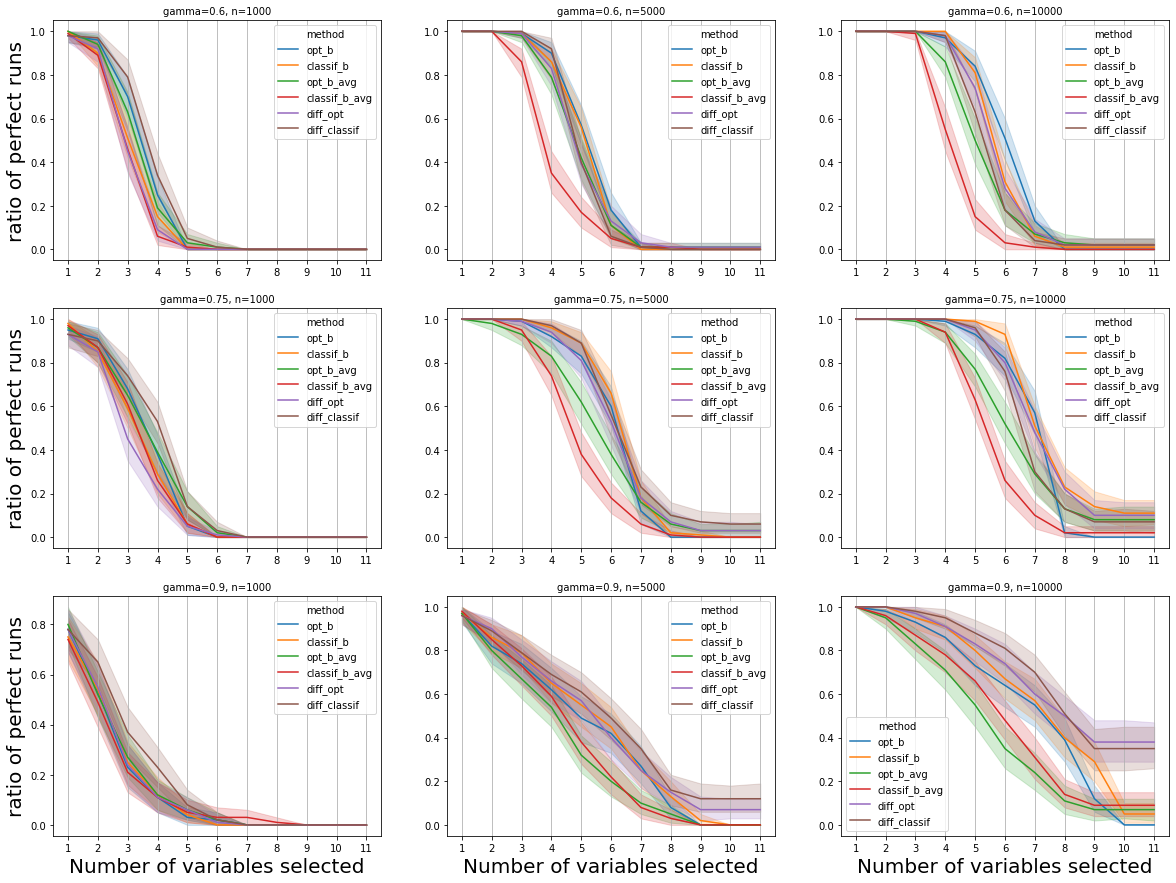

In [12]:
plot_progression()

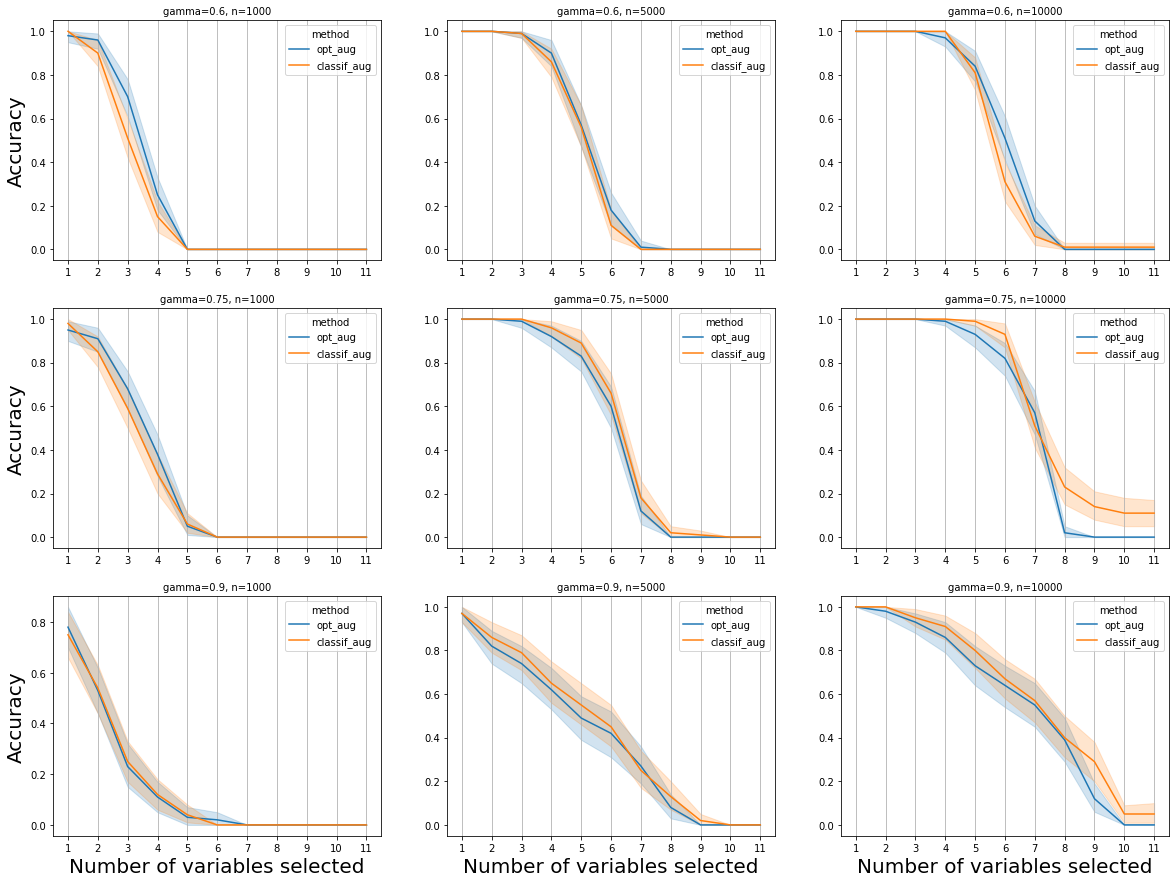

In [16]:
plot_progression(['opt_aug', 'classif_aug'])

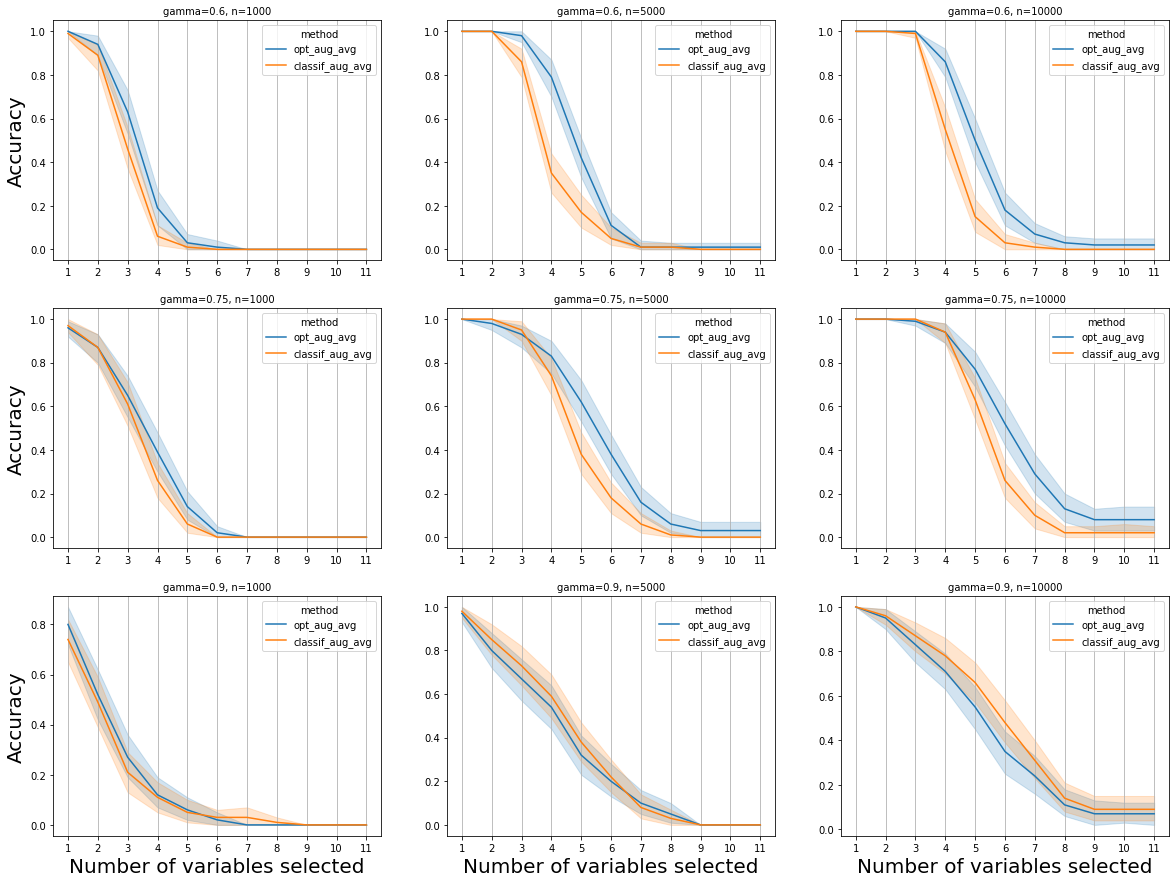

In [17]:
plot_progression(['opt_aug_avg', 'classif_aug_avg'])

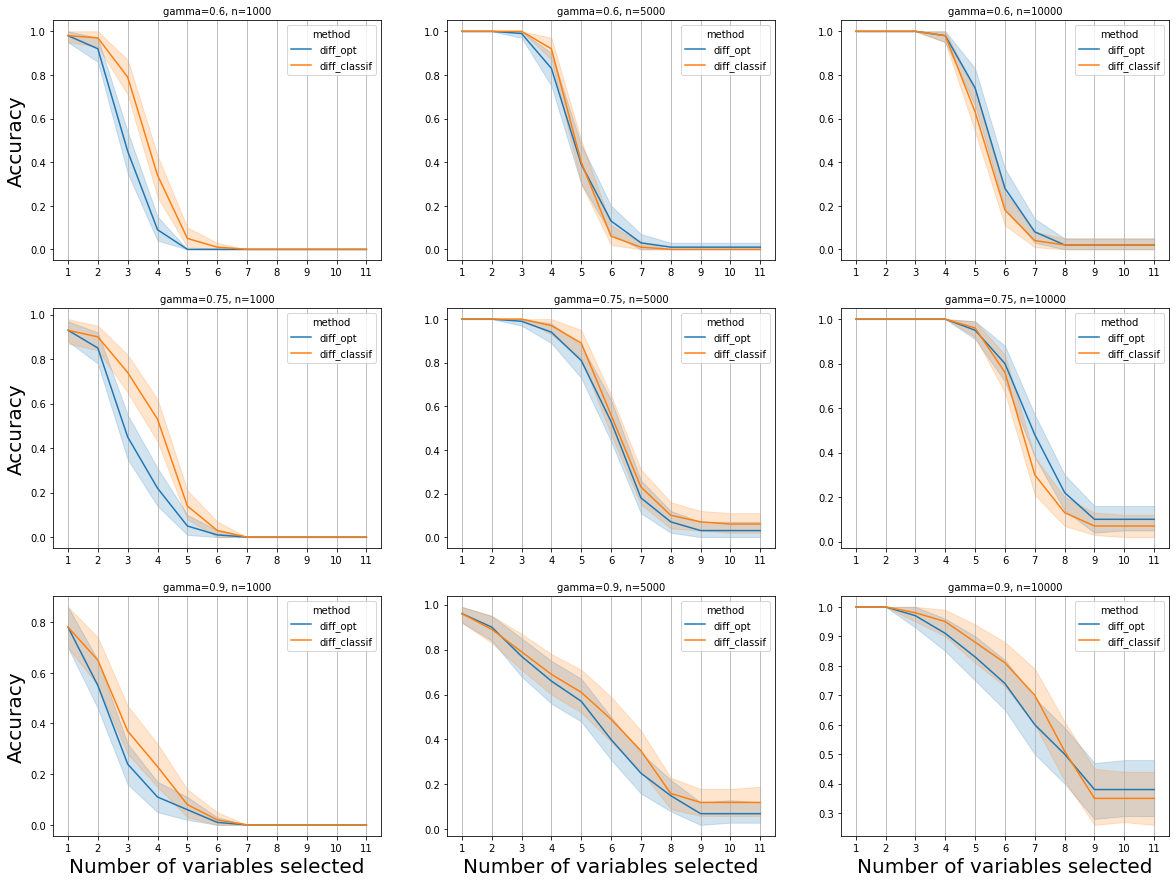

In [18]:
plot_progression(['diff_opt', 'diff_classif'])

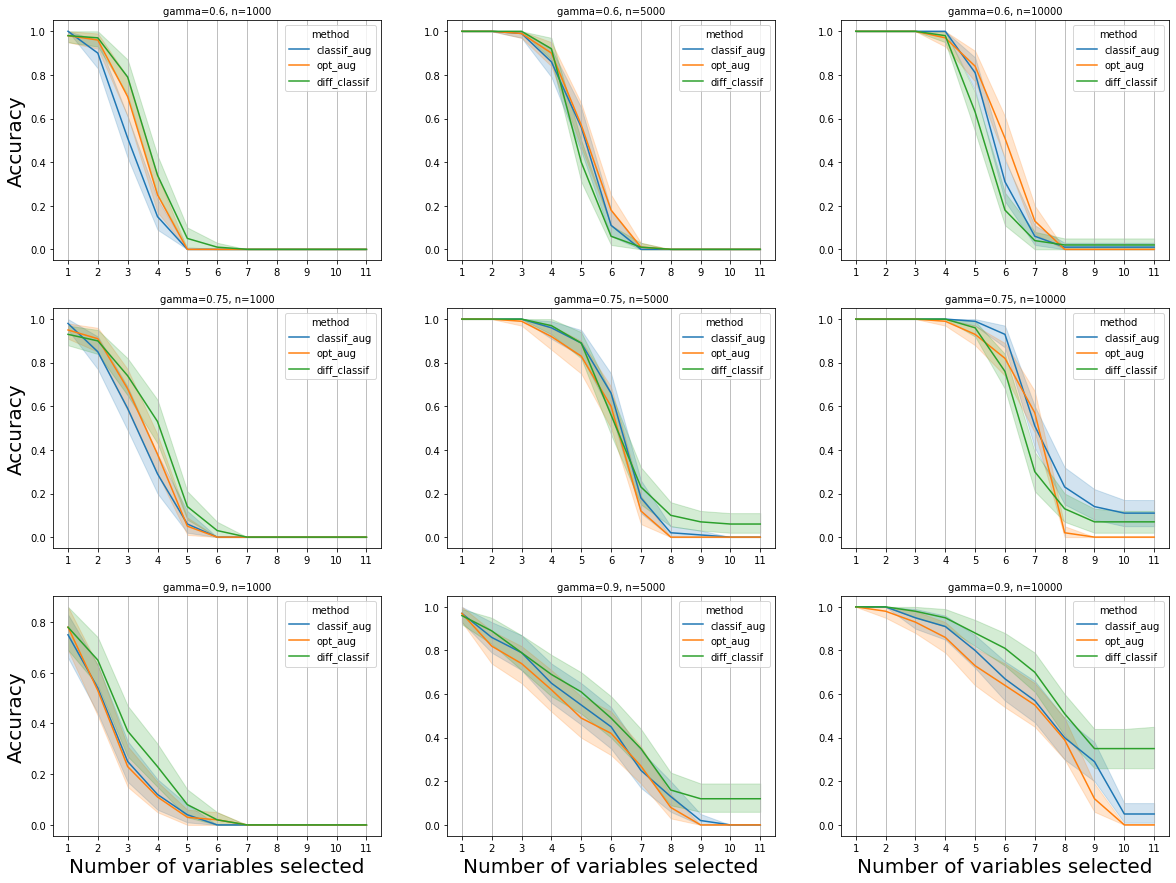

In [20]:
plot_progression(['classif_aug', 'opt_aug', 'diff_classif'])

### Poprawna selekcja

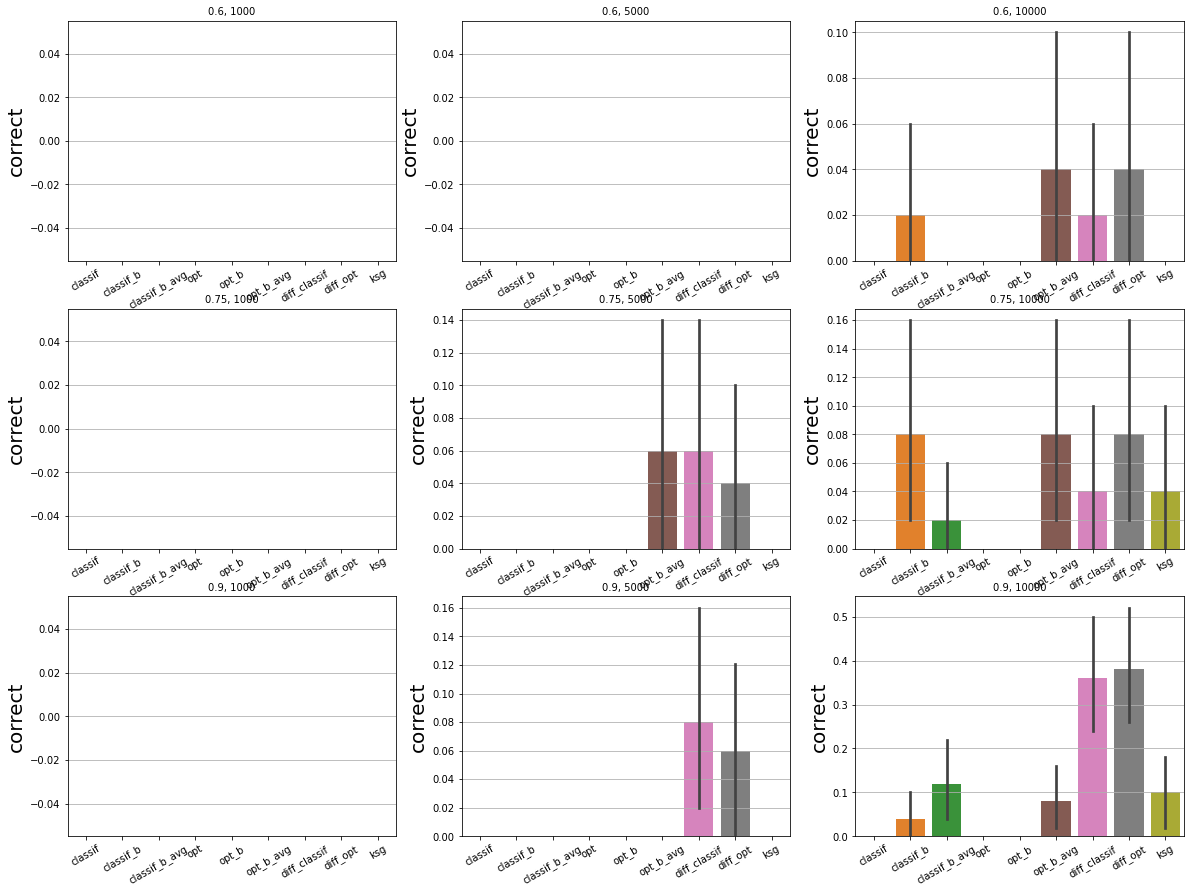

In [47]:
fig, ax = plt.subplots(3, 3)
for i, gamma in enumerate([0.6, 0.75, 0.9]):
    for j, n in enumerate([1000, 5000, 10000]):
        sns.barplot(x='method', y='correct', data=results.set_index(['gamma', 'n']).loc[gamma, n].reset_index(), ax=ax[i][j],
                   order=['classif', 'classif_b', 'classif_b_avg', 'opt', 'opt_b', 'opt_b_avg', 'diff_classif', 'diff_opt', 'ksg'])
        ax[i][j].set_title(f'{gamma}, {n}')
        ax[i][j].set_xlabel(None)
        ax[i][j].grid(axis='y')
        ax[i][j].set_xticklabels(['classif', 'classif_b', 'classif_b_avg', 'opt', 'opt_b', 'opt_b_avg', 'diff_classif', 'diff_opt', 'ksg'], rotation=30)

### Niepotrzebna zmienna na ostatnim miejscu

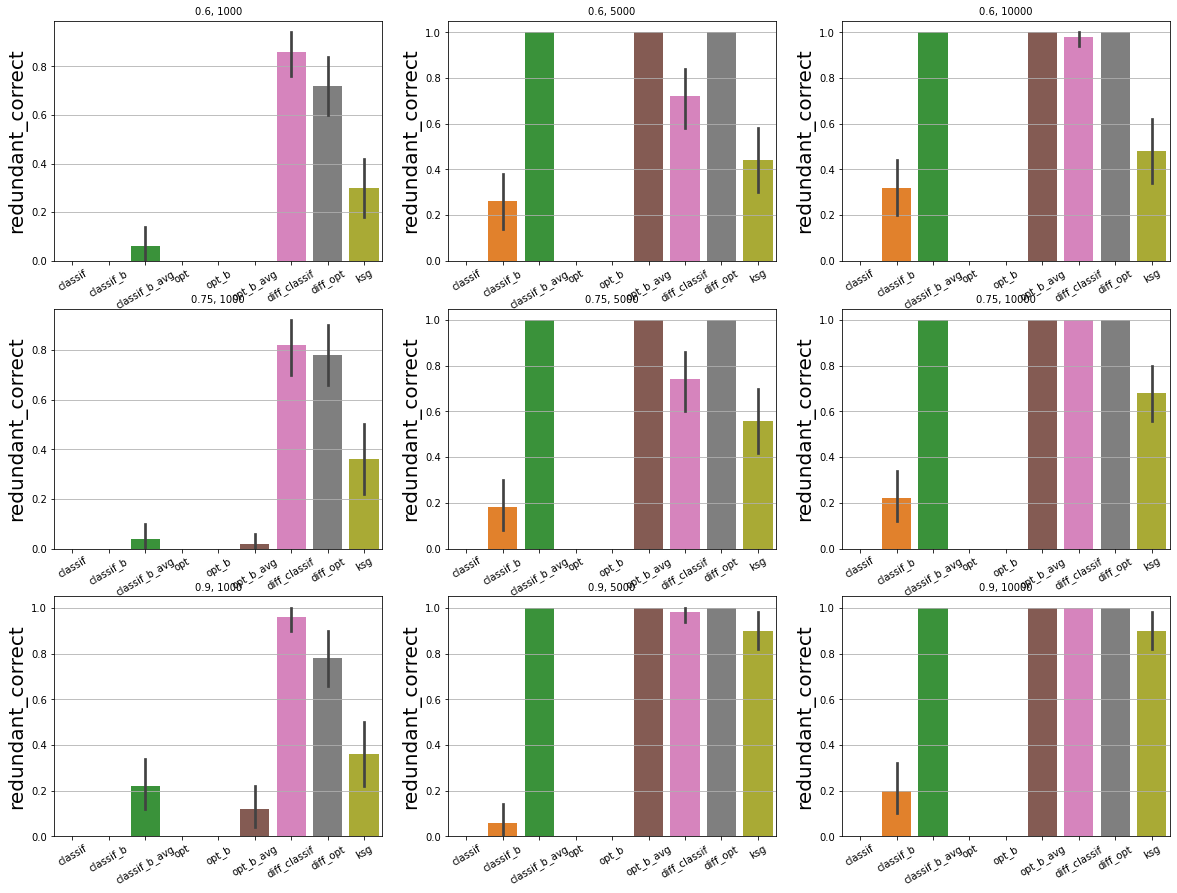

In [48]:
fig, ax = plt.subplots(3, 3)
for i, gamma in enumerate([0.6, 0.75, 0.9]):
    for j, n in enumerate([1000, 5000, 10000]):
        sns.barplot(x='method', y='redundant_correct', data=results.set_index(['gamma', 'n']).loc[gamma, n].reset_index(), ax=ax[i][j],
                   order=['classif', 'classif_b', 'classif_b_avg', 'opt', 'opt_b', 'opt_b_avg', 'diff_classif', 'diff_opt', 'ksg'])
        ax[i][j].set_title(f'{gamma}, {n}')
        ax[i][j].set_xlabel(None)
        ax[i][j].grid(axis='y')
        ax[i][j].set_xticklabels(['classif', 'classif_b', 'classif_b_avg', 'opt', 'opt_b', 'opt_b_avg', 'diff_classif', 'diff_opt', 'ksg'], rotation=30)